# 8. Milestone Project 1: Food Vision Big $^{TM}$

In [1]:
!pip install tensorflow==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394.3 MB 14 kB/s 
     |████████████████████████████████| 3.8 MB 43.1 MB/s 
     |████████████████████████████████| 14.8 MB 52.0 MB/s 
     |████████████████████████████████| 2.9 MB 58.3 MB/s 
     |████████████████████████████████| 132 kB 77.1 MB/s 
     |████████████████████████████████| 462 kB 73.9 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68722 sha256=d924f27ab01c75a9305616d46cf7826b1acfd3afe7d34c6c95ab958014bbcd89
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: numpy
    Found existing installation: n

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

tf.__version__

'2.4.1'

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## What we're going to cover

* Using TensorFlow Datasets to download and explore data (all of Food101)
* Create a preprocessing function for our data
* Batching & preparing datasets for modelling (making them run fast)
* Setting up mixed precision training (faster model training)
* Building and trianing a feature extraction model
* Fine-tuning your feature extraction model to beat the DeepFood paper
* Evaluating your model results on TensorBoard
* Evaluating your model results by making and plotting predictions

small dataset, small model -> larger dataset, small model -> larger dataset, larger model -> Xtra-Large dataset, xtra-large model -> everything we've got

## Check GPU

Google Colab offers free GPUs. However not all of them are compatible of with mixed precision training.

Google Colab offers:
* K80(not compatible)
* P100(not compatible)
* Tesla T4(compatible)

Knowing this in order to use mixed precision training we need access to a Tesla T4 (from within Google Colab) or if we're using our own hardware our GPU needs a score of 7.0+ (see here: https://developer.nvidia.com/cuda-gpus)

In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-81b24e15-8dd4-ed55-14e4-1dad6f503668)


## Get helper functions

In past modules, we've created a bunch of helper functions to do small tasks required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from there.

The script we've got available can be found on Github

In [4]:
# Download the helper functions script
!wget "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"

--2022-07-12 04:38:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-12 04:38:33 (88.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to download data

if you want to get an overview of TensorFlow Datasets (TFDS), read the guide: https://www.tensorflow.org/datasets/overview 

In [6]:
# Get tensorflow datasets
import tensorflow_datasets as tfds

In [7]:
# List all available datasets
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [8]:
# Load in the data (takes 5-6 minutes)

(train_data, test_data), ds_info = tfds.load(name = "food101",
                                             split = ["train", "validation"],
                                             shuffle_files = True,
                                             as_supervised = True,# data gets returned in tuple format (data, label)
                                             with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete9CT8JL/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete9CT8JL/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (eg are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names

In [9]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [10]:
# Get the class_names
class_names = ds_info.features['label'].names

In [11]:
for image, label in train_data.take(1):
    print(f"Image shape: {image.shape}")
    print(f"Image datatype: {image.dtype}")
    print(f"Target class from Food101 (tensor form): {label}")
    print(f"Class name (str form): {class_names[label.numpy()]}")

Image shape: (512, 512, 3)
Image datatype: <dtype: 'uint8'>
Target class from Food101 (tensor form): 16
Class name (str form): cheesecake


Clearly its all unbatched data (no surprises here! even a simple `len` operation would have revealed this). Moreover, the image data is not homogenised (of the same constant shape). Both of these, we'll have to handle later in the pipeline. Our labels are **NOT** one-hot encoded.

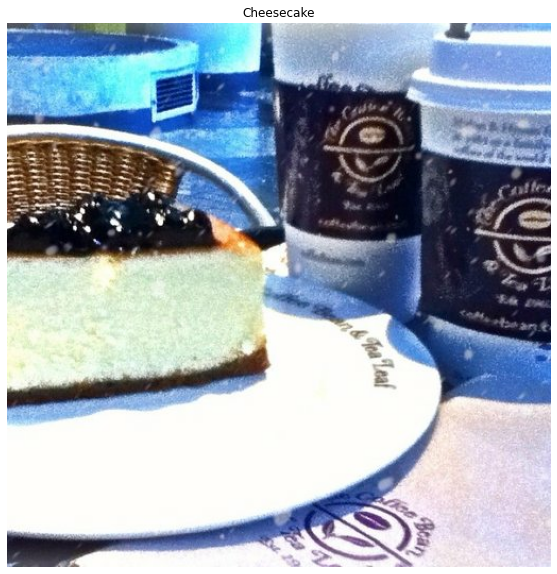

In [12]:
# To check if the labels match up
plt.figure(figsize = (10,10))
plt.imshow(image);
plt.title(f"{class_names[label.numpy()].capitalize()}");
plt.axis(False);

And yeah, we've done all the requisite checks

## Create preprocessing functions for our data

Neural networks perform the best when data is in a certain way (eg. batched, normalised, etc)

However, not all data (including data from TensorFlow Datasets) comes like this

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 and 255)

What we know models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're using an EfficientNetBX pretrained model from tf.keras.applications we don't need to rescale our data (these architectures have rescaling built-in)

This means our functions needs to:
1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from `uint8` to `float32`

In [13]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape = 224):
    """
    Converts image datatype from 'uint8' -> 'float32', scales and reshapes image to [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, size = (img_shape, img_shape))
    # image = image/255. # Not required with EfficientNetBX models
    return tf.cast(image, tf.float32), label

In [14]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n{image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
[[[ 85  84  92]
  [ 86  85  93]
  [ 93  92 100]
  ...
  [120 196 245]
  [120 198 246]
  [121 199 247]]

 [[ 88  88  96]
  [ 82  82  90]
  [ 88  88  96]
  ...
  [116 192 244]
  [118 195 249]
  [119 196 248]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>
Image after preprocessing:
[[[ 84.67857   84.321434  92.321434]
  [ 87.19898   86.841835  94.841835]
  [ 84.72959   84.581635  94.72449 ]
  ...
  [119.50503  194.93877  245.85202 ]
  [114.974525 190.97452  241.90309 ]
  [119.071465 196.4286   247.82652 ]]

 [[ 75.647964  84.21939   93.21939 ]
  [ 71.45407   80.959175  89.959175]
  [ 78.03061   87.20408   97.47449 ]
  ...
  [113.31632  182.62755  249.35715 ]
  [106.57655  176.86227  245.4337  ]
  [108.601944 179.9796   248.16833 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


## Batch and Preprocess Dataset

We're now going to make our data input pipeline run really fast.

For more resources on this, refer to: https://www.tensorflow.org/guide/data_performance

In [15]:
BATCH_SIZE = 32

# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func = preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = BATCH_SIZE).prefetch(buffer_size = tf.data.AUTOTUNE)

# If you have lots of RAM use the .cache() method at the end of train_data batching and preprocessing for even greater speedup

# Map preprocessing function to test data
test_data = test_data.map(map_func = preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(buffer_size = tf.data.AUTOTUNE)

In [16]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

> "Hey, TensorFlow, map this preprocessing function (`preprocess_img`) across the dataset, then shuffle a number of elements and then batch them together and finally make you prepare new batches (prefetch) whilst the model is looking through (finding patterns) in the current batch"

<img src="extras/Artifacts/preparing_datasets.jpeg"></img>

Refer to Hands-On ML with Scikit-Learn, Keras and TensorFlow; Page 422 for details

## Create Modelling Callbacks

* Callbacks are a tool which can add helpful functionality to your models during training evaulation or inference
* Some popular callbacks include:

|Callback name|Use case|Code|
|-------------|--------|----|
|TensorBoard|Log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network paramters). Helpful to compare the results of different models on your model|tf.keras.callbacks.TensorBoard()|
|Model checkpointing|Save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting|tf.keras.callbacks.ModelCheckpoint()|
|Early stopping|Leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take|tf.keras.callbacks.EarlyStopping()|

In [26]:
# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "/content/drive/MyDrive/TensorFlow Developer Certification/Checkpoints/Classification/model_checkpoint.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_weights_only=True,
                                                      save_best_only=True,
                                                      save_freq='epoch',
                                                      monitor='val_accuracy',
                                                      verbose = 0 # don't print whether model is being saved
                                                      )

## Setup Mixed Precision Training

First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision: https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance

In [18]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [19]:
mixed_precision.global_policy()

<Policy "mixed_float16">

The mixed precision policy has the greatest speed-up for large models. With smaller models, the speedup isn't that observable

## Build feature extraction model

In [30]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape = input_shape, name = "input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model doesn't you can have a layer like below
# x = preprocessing.Rescaling(1./255)(x)

x = base_model(inputs, training = False) # makes sure that layers that should be in inference only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype = tf.float32, name = "softmax_float32")(x) # done to ensure numeric stability; need to separate the dense and the activation layers like this
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [24]:
for num_layer, layer in enumerate(model.layers):
  print(f'{num_layer}. {layer.name} -> {layer.dtype}, {layer.dtype_policy}')

0. input_layer -> float32, <Policy "float32">
1. efficientnetb0 -> float32, <Policy "mixed_float16">
2. global_average_pooling2d -> float32, <Policy "mixed_float16">
3. dense -> float32, <Policy "mixed_float16">
4. softmax_float32 -> float32, <Policy "float32">


In [23]:
for num_layer, layer in enumerate(model.layers[1].layers):
  print(f'{num_layer}. {layer.name} -> {layer.dtype}, {layer.dtype_policy}')

0. input_1 -> float32, <Policy "float32">
1. rescaling -> float32, <Policy "mixed_float16">
2. normalization -> float32, <Policy "float32">
3. stem_conv_pad -> float32, <Policy "mixed_float16">
4. stem_conv -> float32, <Policy "mixed_float16">
5. stem_bn -> float32, <Policy "mixed_float16">
6. stem_activation -> float32, <Policy "mixed_float16">
7. block1a_dwconv -> float32, <Policy "mixed_float16">
8. block1a_bn -> float32, <Policy "mixed_float16">
9. block1a_activation -> float32, <Policy "mixed_float16">
10. block1a_se_squeeze -> float32, <Policy "mixed_float16">
11. block1a_se_reshape -> float32, <Policy "mixed_float16">
12. block1a_se_reduce -> float32, <Policy "mixed_float16">
13. block1a_se_expand -> float32, <Policy "mixed_float16">
14. block1a_se_excite -> float32, <Policy "mixed_float16">
15. block1a_project_conv -> float32, <Policy "mixed_float16">
16. block1a_project_bn -> float32, <Policy "mixed_float16">
17. block2a_expand_conv -> float32, <Policy "mixed_float16">
18. blo

In [31]:
history_init = model.fit(
    train_data,
    epochs = 3,
    steps_per_epoch = len(train_data),
    validation_data = test_data,
    validation_steps = int(0.15*len(test_data)),
    callbacks = [model_checkpoint, create_tensorboard_callback('/content/drive/MyDrive/TensorFlow Developer Certification/Tensorboard/Classification', 'food_vision_big')]
)

Saving TensorBoard log files to: /content/drive/MyDrive/TensorFlow Developer Certification/Tensorboard/Classification/food_vision_big/20220712-051327
Epoch 1/3
2368/2368 [==============================] - 196s 74ms/step - loss: 2.3352 - accuracy: 0.4638 - val_loss: 1.2334 - val_accuracy: 0.6753
Epoch 2/3
2368/2368 [==============================] - 165s 69ms/step - loss: 1.3169 - accuracy: 0.6629 - val_loss: 1.1199 - val_accuracy: 0.7007
Epoch 3/3
2368/2368 [==============================] - 167s 70ms/step - loss: 1.1438 - accuracy: 0.7025 - val_loss: 1.0963 - val_accuracy: 0.7021


In [32]:
results_init = model.evaluate(test_data)
results_init

790/790 [==============================] - 49s 61ms/step - loss: 1.0946 - accuracy: 0.7058


[1.0945899486541748, 0.7057821750640869]

## Next Steps:

Next we need to obtain a computer vision model (building of the one we've built in this notebook) to beat the DeepFood paper